Loading Libraries:

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [24]:
from torchvision.io import read_image
from torchvision.transforms import functional as TF

file_path = '/Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-73.631,45.410493.jpg'

image = read_image(file_path)
image = TF.resize(image, (350, 350))
image = image.float() / 255.0  # Normalize to range [0, 1]

print("Loaded image shape:", image.shape)  # Should be [3, 350, 350]

assert image.min() >= 0 and image.max() <= 1, "Image values should be in the range [0, 1]"



Loaded image shape: torch.Size([3, 350, 350])


Step 1: Let's define the VAE model

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(112896, 512)  # mu layer
        self.fc2 = nn.Linear(112896, 512)  # logvar layer
        self.fc3 = nn.Linear(512, 112896) # 112,896 = 256 * 21 * 21

        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 21, 21)),  # Unflatten to the size before the last encoder conv layer
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
            nn.AdaptiveAvgPool2d((350, 350))
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc1(h1), self.fc2(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc3(z)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Step 2: Define the dataset class for loading images and extracting geolocation

In [27]:
train_dir = '/Users/joe/Repos/Charbel/Project1/Data/train' 
test_dir = '/Users/joe/Repos/Charbel/Project1/Data/test' 

In [18]:
from torchvision.transforms import functional as TF

class GeoTaggedImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.directory) for f in filenames if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = read_image(img_path)
            image = TF.resize(image, (350, 350))
            image = image.float() / 255.0  # Normalized to range [0, 1]
        
            if self.transform:
                image = self.transform(image)

            filename = os.path.basename(img_path)
            lat, lon = map(float, filename.rstrip('.jpg').split(','))
            return image, torch.tensor([lat, lon])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Skip this image and load the next one
            return self.__getitem__((idx + 1) % len(self))


Step 3: Set up the training and testing processes

In [33]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


train_dataset = GeoTaggedImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = GeoTaggedImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch_idx, (data, _) in enumerate(train_loader): ##Test
    print(f"Batch {batch_idx} - Data shape: {data.shape}")  # Expected to be [32, 3, 350, 350]
    if batch_idx == 0:  # We only need to check the first batch
        break
    
for batch_idx, (data, _) in enumerate(train_loader):
    print(f"Batch {batch_idx}: Max value = {data.max().item()}, Min value = {data.min().item()}")
    if batch_idx == 0: 
        break
    
def train(epoch, train_loader):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        print(f"Max target value: {data.max().item()}, Min target value: {data.min().item()}")
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Batch {batch_idx}: Max value = {data.max()}, Min value = {data.min()}")
    print(f'Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    recon_batch, mu, logvar = vae(data)
    print(f"Reconstructed - Max: {recon_batch.max().item()}, Min: {recon_batch.min().item()}")


def test(epoch, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = vae(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    print(f'Test set loss: {test_loss / len(test_loader.dataset):.4f}')
    
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch, train_loader)
    test(epoch, test_loader)


Batch 0 - Data shape: torch.Size([32, 3, 350, 350])
Batch 0: Max value = 1.0, Min value = 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max target value: 1.0, Min target value: 0.0
Max ta

In [34]:
for batch_idx, (data, _) in enumerate(train_loader):
    print(f"Max target value: {data.max().item()}, Min target value: {data.min().item()}")
    if batch_idx == 0: 
        break


Max target value: 1.0, Min target value: 0.0


Step 4: Let's save the model: Saved the State Dictionary or Entire Model

State Dictinory 

In [40]:
# Saving the model's state_dict. I deleted this file, it doesn't fit on git repo, it exceeds 500 MB.
torch.save(vae.state_dict(), 'vae_model.pth')


In [7]:
vae = VAE()  # Instantiating the model
vae.load_state_dict(torch.load('vae_model.pth')) # Loading the saved state_dict
vae.eval()  # Set to evaluation mode


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=112896, out_features=512, bias=True)
  (fc2): Linear(in_features=112896, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=112896, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(256, 21, 21))
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(

Ste5: Let's create Images using the model

In [3]:

with torch.no_grad():
    random_latent_vectors = torch.randn(10, 512).to(device)  # 10 samples

    
    generated_images = vae.decode(random_latent_vectors)


NameError: name 'device' is not defined

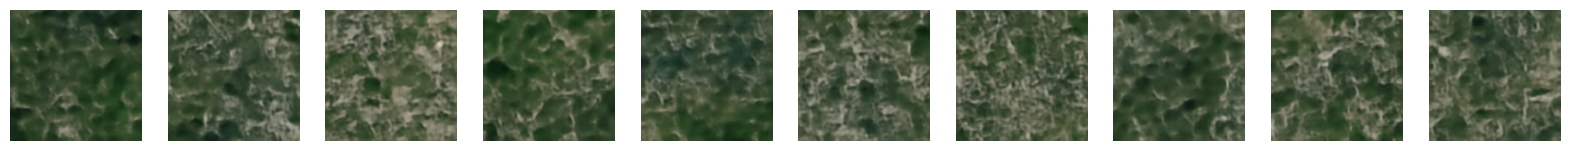

In [14]:

num_images = 10


latent_size = 512

vae.eval()


random_latent_vectors = torch.randn(num_images, latent_size).to(device)


with torch.no_grad():
    generated_images = vae.decode(random_latent_vectors)


generated_images = generated_images.cpu().numpy()


def show_generated_images(images, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].transpose(1, 2, 0))
        ax.axis('off')
    plt.show()


show_generated_images(generated_images, num_images)


In [45]:
# Saving the entire model. I deleted this file, it doesn't fit on git repo, it exceeds 500 MB.
torch.save(vae, 'vae_model_complete.pth')



Visual inspection of reconstructed image:

In [19]:
train_dir = '/Users/joe/Repos/Charbel/Project1/Data/train' 
test_dir = '/Users/joe/Repos/Charbel/Project1/Data/test' 

train_dataset = GeoTaggedImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = GeoTaggedImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

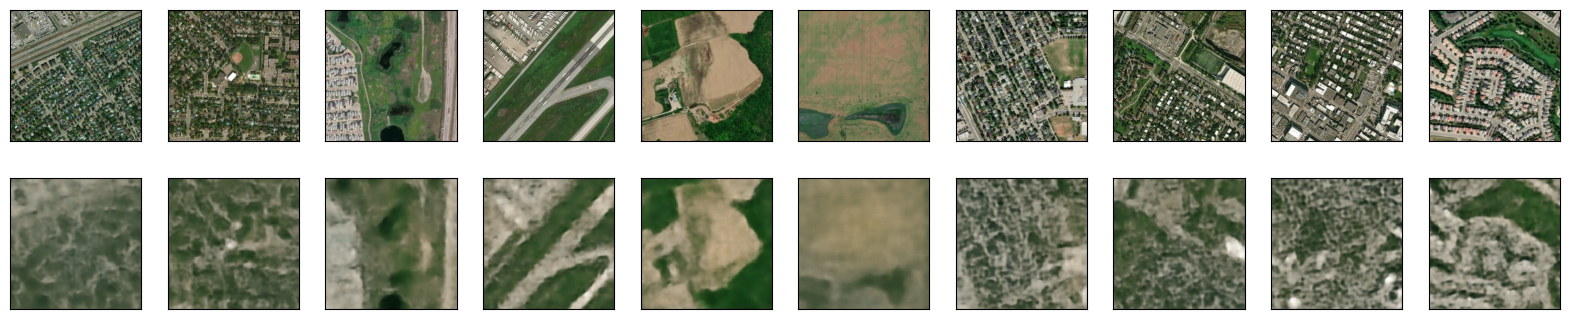

In [20]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        #original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        #reconstruction
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


test_data, _ = next(iter(test_loader))


test_data = test_data.to(device)
with torch.no_grad():
    reconstructed, _, _ = vae(test_data)

#original and reconstructed images
show_images(test_data, reconstructed)


In [22]:
mse_loss = torch.nn.MSELoss(reduction='mean')

def calculate_mse(test_loader, model):
    model.eval()
    total_mse = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            mse = mse_loss(recon, data)
            total_mse += mse.item()
    return total_mse / len(test_loader)

test_mse = calculate_mse(test_loader, vae)
print(f"Test MSE: {test_mse}")


Error loading image /Users/joe/Desktop/pytest/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated
Test MSE: 0.010850524041697686


Let's evaluate this model: Latent Space Interpolation & Random Sampling from Latent Space

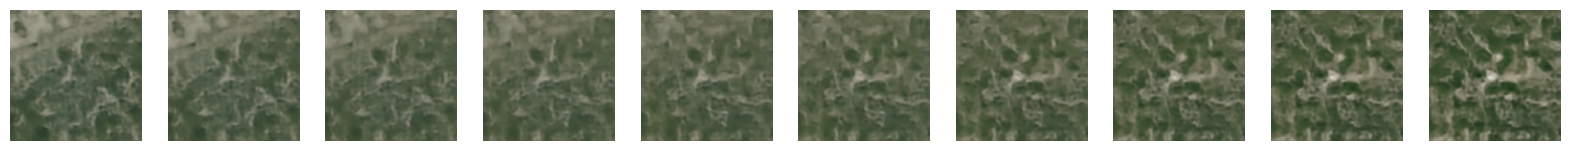

In [34]:
#Latent Space Interpolation

import torch
import numpy as np
import matplotlib.pyplot as plt


def interpolate_latent_space(vae, start_data, end_data, steps=10):
    vae.eval()
    interpolated_images = []
    with torch.no_grad():

        start_latent, _ = vae.encode(start_data.to(device))
        end_latent, _ = vae.encode(end_data.to(device))


        for alpha in np.linspace(0, 1, steps):
            inter_latent = (1 - alpha) * start_latent + alpha * end_latent
            inter_image = vae.decode(inter_latent).cpu()
            interpolated_images.append(inter_image)

    return interpolated_images


test_images, _ = next(iter(test_loader))
img1 = test_images[0].unsqueeze(0)  
img2 = test_images[1].unsqueeze(0)  

# Interpolate and generate
interpolated_images = interpolate_latent_space(vae, img1, img2)


def show_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(0).permute(1, 2, 0))
        ax.axis('off')
    plt.show()


show_images(interpolated_images, len(interpolated_images))


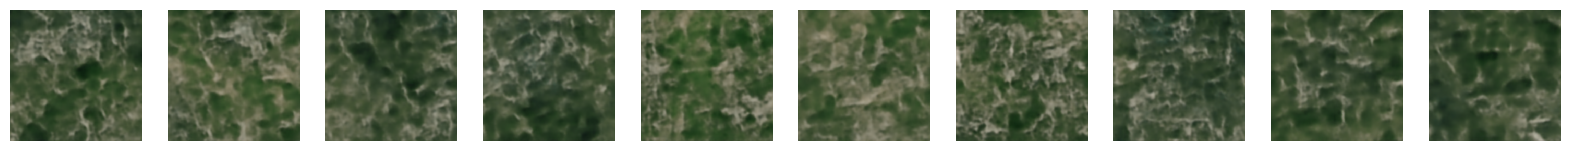

In [35]:
#Random Sampling from Latent Space

def generate_random_samples(vae, latent_dim, num_samples):
    vae.eval()
    with torch.no_grad():
        random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)
        generated_images = vae.decode(random_latent_vectors).cpu()
        return generated_images

latent_dim = 512  # Size of the latent space
num_samples = 10  # Number of images to generate
random_samples = generate_random_samples(vae, latent_dim, num_samples)

show_images(random_samples, num_samples)












Part II- Let's use wilfire non-wildfire classification for training a predictive model.

Step 1: Extract Features and Geocodes Using VAE

In [98]:
from torch.utils.data import DataLoader


train_dir = '/Users/joe/Repos/Charbel/Project1/Data/train' 
train_dataset = GeoTaggedImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



test_dir = '/Users/joe/Repos/Charbel/Project1/Data/test' 
test_dataset = GeoTaggedImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


validation_dir = '/Users/joe/Repos/Charbel/Project1/Data/valid' 
validation_dataset = GeoTaggedImageDataset(validation_dir)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)


In [99]:

def extract_vae_features_and_geocodes(vae, loader):
    vae.eval()
    features, geocodes, labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            try:
                images, coords, lbls = batch
                images = images.to(device)
                latent, _ = vae.encode(images)
                features.extend(latent.cpu().numpy())
                geocodes.extend(coords.numpy())
                labels.extend(lbls.numpy())
            except RuntimeError as e:
                print(f"Skipping a batch due to an error: {e}")
                continue
    return np.array(features), np.array(geocodes), np.array(labels)


The following two images are incomplete or truncated, so i deleted them from the folders:

Error loading image /Users/joe/Desktop/pytest/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Error loading image /Users/joe/Desktop/pytest/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated

Step 2: Combine Features with Geocode Data

In [3]:
#modifying the GeoTaggedImageDataset class to include labels based on the folder names:

from torchvision.io import read_image
from torchvision.transforms import functional as TF
from PIL import Image
import os
from torch.utils.data import Dataset
import torch

class GeoTaggedImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_folder in ['wildfire', 'nowildfire']:
            label = 1 if label_folder == 'wildfire' else 0
            folder_path = os.path.join(directory, label_folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith('.jpg'):
                    if self.is_valid_image(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(label)

    @staticmethod
    def is_valid_image(file_path):
        try:
            with Image.open(file_path) as img:
                img.verify()
            return True
        except Exception:
            return False

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = read_image(img_path)
            image = TF.resize(image, (350, 350))
            image = image.float() / 255.0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = torch.zeros(3, 350, 350)

        if self.transform:
            image = self.transform(image)

        filename = os.path.basename(img_path)
        lat, lon = map(float, filename.rstrip('.jpg').split(','))
        label = self.labels[idx]

        return image, torch.tensor([lat, lon]), label


In [100]:

train_features, train_geocodes, train_labels = extract_vae_features_and_geocodes(vae, train_loader)
test_features, test_geocodes, test_labels = extract_vae_features_and_geocodes(vae, test_loader)
validation_features, validation_geocodes, validation_labels = extract_vae_features_and_geocodes(vae, validation_loader)


Error loading image /Users/joe/Desktop/pytest/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Error loading image /Users/joe/Desktop/pytest/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated


In [101]:
#Combining the VAE features with the geocode data to create your training, testing, and validation datasets

train_data = np.concatenate((train_features, train_geocodes), axis=1)
test_data = np.concatenate((test_features, test_geocodes), axis=1)
validation_data = np.concatenate((validation_features, validation_geocodes), axis=1)

Step 3: Train a Logistic Regression Classifier

In [105]:
from sklearn.preprocessing import StandardScaler

# Scale
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)
validation_data_scaled = scaler.transform(validation_data)

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initializing and training the logistic regression model
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(train_data_scaled, train_labels)

# Evaluating on the test set
test_predictions = logistic_model.predict(test_data_scaled)
print(f"Test Accuracy: {accuracy_score(test_labels, test_predictions)}")
print(classification_report(test_labels, test_predictions))


Test Accuracy: 0.9747619047619047
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2820
           1       0.99      0.97      0.98      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.98      0.97      6300
weighted avg       0.98      0.97      0.97      6300



Step 4: Validation

In [108]:

validation_predictions = logistic_model.predict(validation_data_scaled)
print(f"Validation Accuracy: {accuracy_score(validation_labels, validation_predictions)}")
print(classification_report(validation_labels, validation_predictions))


Validation Accuracy: 0.9747619047619047
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2820
           1       0.98      0.97      0.98      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.98      0.97      6300
weighted avg       0.97      0.97      0.97      6300



Step 5: Confusion Matrix, ROC, and AIC on Test Data Scaled and Validation Data Scaled 

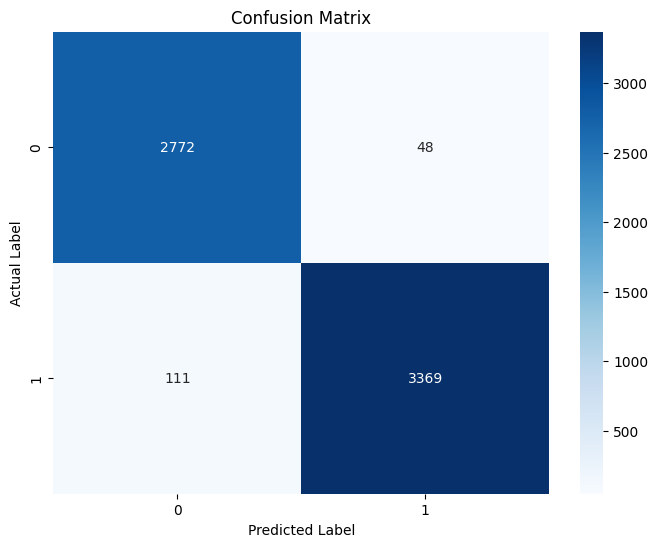

In [110]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


test_predictions = logistic_model.predict(test_data_scaled)


cm = confusion_matrix(test_labels, test_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


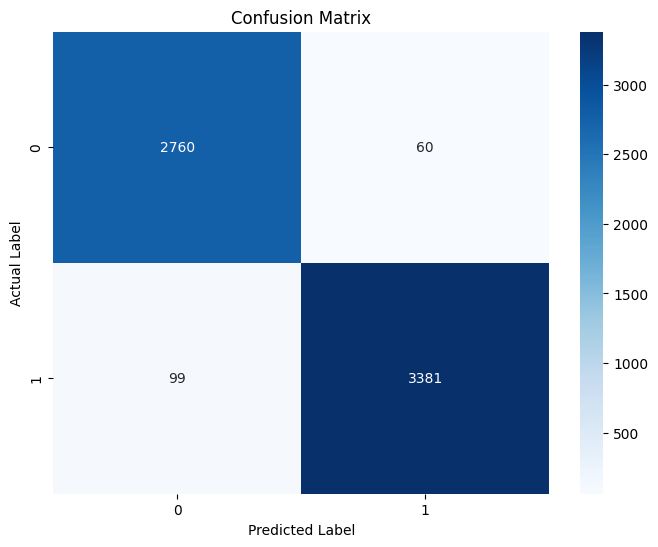

In [113]:
validation_predictions = logistic_model.predict(validation_data_scaled)


cm = confusion_matrix(validation_labels, validation_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Area Under Curve (AUC): 0.9980697195728376


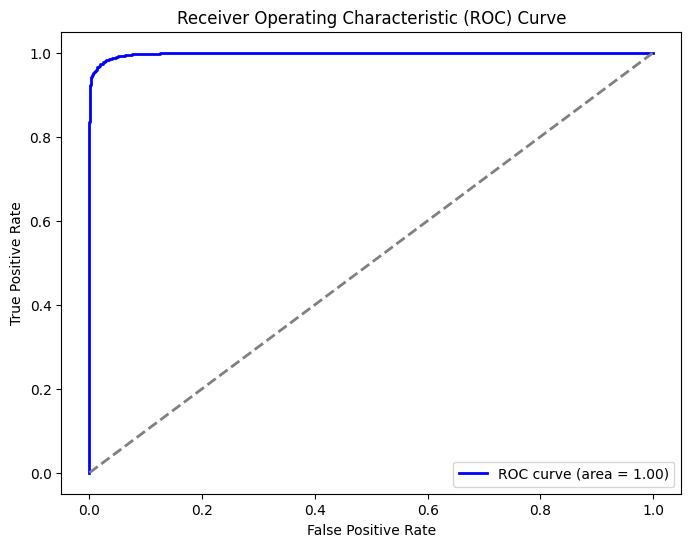

In [111]:

test_probabilities = logistic_model.predict_proba(test_data_scaled)[:, 1]


auc = roc_auc_score(test_labels, test_probabilities)
print(f"Area Under Curve (AUC): {auc}")


fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Area Under Curve (AUC): 0.9978207793266487


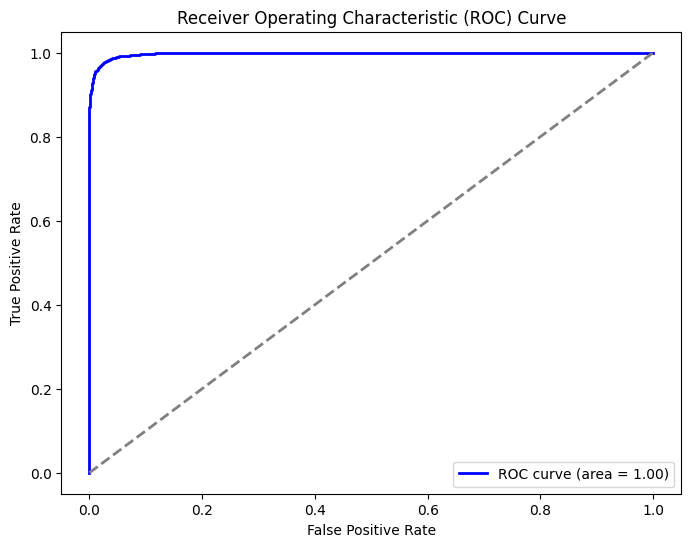

In [114]:

validation_probabilities = logistic_model.predict_proba(validation_data_scaled)[:, 1]


auc = roc_auc_score(validation_labels, validation_probabilities)
print(f"Area Under Curve (AUC): {auc}")


fpr, tpr, thresholds = roc_curve(validation_labels, validation_probabilities)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [112]:
from sklearn.metrics import log_loss
import numpy as np


k = logistic_model.coef_.shape[1] + 1


log_likelihood = -log_loss(test_labels, logistic_model.predict_proba(test_data_scaled), normalize=False)


aic = 2 * k - 2 * log_likelihood
print(f"AIC: {aic}")


AIC: 1772.3829167038734


In [115]:

k = logistic_model.coef_.shape[1] + 1


log_likelihood = -log_loss(validation_labels, logistic_model.predict_proba(validation_data_scaled), normalize=False)


aic = 2 * k - 2 * log_likelihood
print(f"AIC: {aic}")

AIC: 1806.4663761452275


Phase III - Benchmark with ResNet-50

In [1]:
#Step 1: Setting Up ResNet-50 for Binary Classification
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


model = models.resnet50(pretrained=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/Users/joe/Repos/Charbel/Project1/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/joe/Repos/Charbel/Project1/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/joe/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [4]:
#Step 2: Data Preparation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dir = '/Users/joe/Repos/Charbel/Project1/Data/train' 
train_dataset = GeoTaggedImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



test_dir = '/Users/joe/Repos/Charbel/Project1/Data/test' 
test_dataset = GeoTaggedImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


validation_dir = '/Users/joe/Repos/Charbel/Project1/Data/valid' 
validation_dataset = GeoTaggedImageDataset(validation_dir)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [6]:
#Step 3: Training the Model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, _, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")


Error loading image /Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Epoch 1, Loss: 0.14452972410967374
Error loading image /Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Epoch 2, Loss: 0.10379498139152749
Error loading image /Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Epoch 3, Loss: 0.08201776519191331
Error loading image /Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Epoch 4, Loss: 0.07171154873648435
Error loading image /Users/joe/Repos/Charbel/Project1/Data/train/nowildfire/-114.152378,51.027198.jpg: Image is incomplete or truncated
Epoch 5, Loss: 0.06817666880737687


In [7]:
#Let's save the model. I deleted this file, it doesn't fit on git repo, it exceeds 500 MB.


torch.save(model.state_dict(), 'resnet50_model.pth')

In [8]:
#Step 4: Evaluating the Model
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for images, _, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print(classification_report(true_labels, predictions))
    print(f"Accuracy: {accuracy_score(true_labels, predictions)}")


evaluate_model(model, test_loader)


Error loading image /Users/joe/Repos/Charbel/Project1/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2820
           1       0.99      0.96      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300

Accuracy: 0.9779365079365079


In [14]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


conf_matrix_test = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig('confusion_matrix_resNet50_test.png', bbox_inches='tight')
plt.close()


In [15]:

conf_matrix_validation = confusion_matrix(validation_labels, validation_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')


plt.savefig('confusion_matrix_resNet50_validation.png', bbox_inches='tight')
plt.close()


Confusion Matrix and ROC on Resnet-50:

In [10]:


def get_predictions_and_labels(model, loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, _, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels


Error loading image /Users/joe/Repos/Charbel/Project1/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated


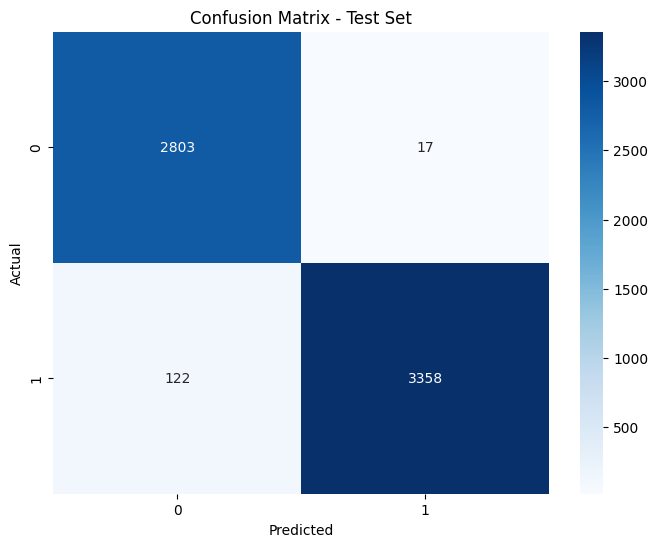

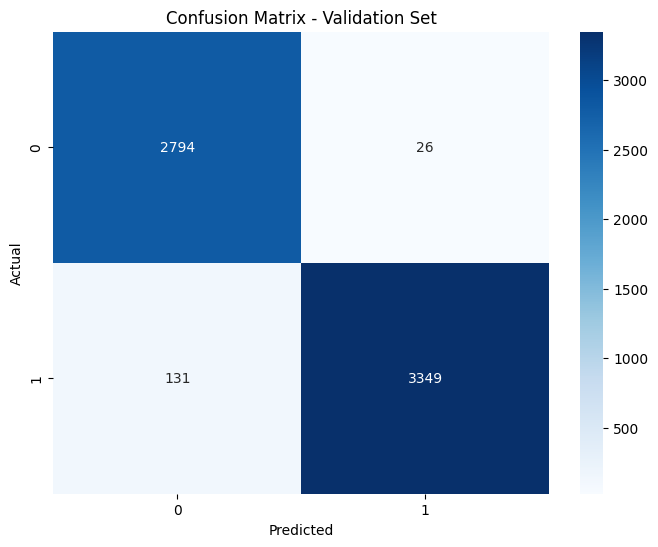

In [13]:

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


test_predictions, test_labels = get_predictions_and_labels(model, test_loader)
conf_matrix_test = confusion_matrix(test_labels, test_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

validation_predictions, validation_labels = get_predictions_and_labels(model, validation_loader)
conf_matrix_validation = confusion_matrix(validation_labels, validation_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [12]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_and_save_roc_curve(model, loader, filename):
    model.eval()
    actuals = []
    probabilities = []

    with torch.no_grad():
        for images, _, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probability = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            actuals.extend(labels.cpu().numpy())
            probabilities.extend(probability.cpu().numpy())

    fpr, tpr, _ = roc_curve(actuals, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')


    plt.savefig(filename, bbox_inches='tight')
    plt.close()


plot_and_save_roc_curve(model, test_loader, 'roc_curve_test.png')
plot_and_save_roc_curve(model, validation_loader, 'roc_curve_validation.png')



Error loading image /Users/joe/Repos/Charbel/Project1/Data/test/wildfire/-73.15884,46.38819.jpg: Image is incomplete or truncated
